# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*

In [2]:
## Excess rainfall parameters:
CN  = 73       # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 20   #inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3700 #Upper Limit of recurrence interval evaluation, Suggest not changing this value
Aerial_Reduction = 1.0 #Aerial Reduction Factor

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'DesPlaines'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN =         '071200040403'   # Domain/boundary condition name

#NOAA Data
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN) 
#Mean Precip Curve Data
precip_mean_curve_table = '{0}_{1}_{2}_MeanCurve.csv'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### NOAA Atlas 14 Precipitation Values

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959


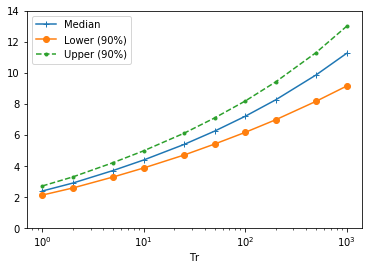

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 14))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#reduce precip by aerial reduction factor
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

#Find GEV parameters for the median curve
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
GEV_parameters_M =df_GEV_parameters_M.to_numpy().transpose()[0]

#Find GEV parameters for the upper curve of the 90% confidence interval
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
GEV_parameters_U =df_GEV_parameters_U.to_numpy().transpose()[0]

#Find GEV parameters for the lower curve of the 90% confidence interval
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
GEV_parameters_L =df_GEV_parameters_L.to_numpy().transpose()[0]

dfs = [df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04256935345698326
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032377611868098656
            Iterations: 19
            Function evaluations: 106
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.056679706305320314
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13


,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.755150,2.446070,3.139833
sigma,0.574647,0.532820,0.627433
xi,-0.204410,-0.163136,-0.222317


### Plot Fitted GEV Distribution and NOAA Data

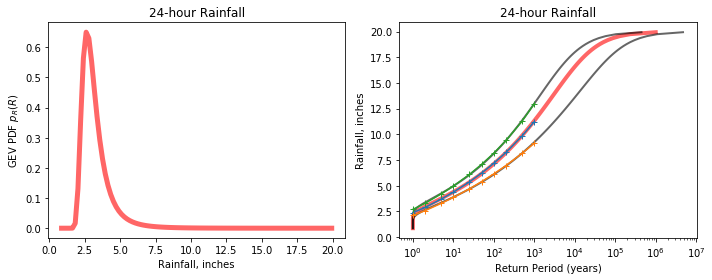

In [7]:
# Define figure including figure dimensions
fig, ((fig1a, fig1b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#fig, ax = plt.subplots(1, 1)

Precip = np.linspace(PPF_GEV(10**-100, GEV_parameters_M, PMP),PPF_GEV(.999999, GEV_parameters_M, PMP), 100)

Return_Period_Precip_E=1/(1-CDF_GEV(Precip, GEV_parameters_M, PMP))
Return_Period_Precip_L=1/(1-CDF_GEV(Precip, GEV_parameters_L, PMP))
Return_Period_Precip_U=1/(1-CDF_GEV(Precip, GEV_parameters_U, PMP))

#Create First Panel Figure
fig1a.plot(Precip, PDF_GEV(Precip, GEV_parameters_M, PMP) ,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
fig1a.set_xlabel('Rainfall, inches'),fig1a.set_ylabel('GEV PDF $p_R(R)$'), fig1a.set_title('24-hour Rainfall')

#Create Second Panel Figure

fig1b.set_xscale('log')
fig1b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=4, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_L, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_U, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
raw_precip_reduced['Median'].plot(style=['+-','o-','.--','s:'],logx=True)
raw_precip_reduced['Lower (90%)'].plot(style=['+-','o-','.--','s:'],logx=True )
raw_precip_reduced['Upper (90%)'].plot(style=['+-','o-','.--','s:'],logx=True)
fig1b.set_xlabel('Return Period (years)'),fig1b.set_ylabel('Rainfall, inches'), fig1b.set_title('24-hour Rainfall')

plt.tight_layout()
plt.show()

### Data for Calculating the Mean Curve

In [8]:
#Additional Return Intervals evaluated for the mean curve
Return_Intervals_MC =  np.array([ 1.01, 1.05, 1.11, 1.25, 20,\
                                 2000, 5000, 10000, 20000,\
                                 50000., 100000., 200000., 1/2E-06,\
                                1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07 ]) 

Mean_Curve_data = Mean_Curve_RI_data(raw_precip_reduced, Return_Intervals_MC, GEV_parameters_M, GEV_parameters_L, GEV_parameters_U, PMP)
Mean_Curve_data 

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.379714,2.117918,2.702459,0.070849,0.077314,0.077314,0.866980
1.01,2.000418,1.724906,2.326368,0.090081,0.091764,0.091764,0.693356
1.05,2.182937,1.903610,2.520997,0.083234,0.087528,0.087528,0.780671
1.11,2.312590,2.028762,2.660104,0.079600,0.085105,0.085105,0.838368
1.25,2.494542,2.202098,2.856443,0.075802,0.082354,0.082354,0.914105
2.00,2.891592,2.574480,3.286755,0.070614,0.077868,0.077868,1.061807
5.00,3.701163,3.283337,4.207439,0.072819,0.077937,0.077937,1.308647
10.00,4.377602,3.863020,4.969184,0.076019,0.077054,0.077054,1.476501
20.00,5.101648,4.482087,5.776025,0.078708,0.075472,0.078708,1.629564
25.00,5.377439,4.696378,6.100418,0.082323,0.076684,0.082323,1.682212


### Input for Calculating the Mean Curve

In [9]:
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, .99, 0.995, 0.999])

mu_LN =Mean_Curve_data['mu LN'].to_numpy()
SD = Mean_Curve_data['Max Log SD'].to_numpy()

data= [[stats.lognorm.ppf(CL1/Norm_Constant_LN(SD1, mu1, PMP) , SD1, scale = np.exp(mu1) )  for CL1 in CL ] for mu1, SD1 in zip(mu_LN, SD) ]

df_input = pd.DataFrame(data=data, columns = CL, index =  1/Mean_Curve_data.index.to_numpy()).sort_index(axis=0 ,ascending=True)

df_input.index.name ='AEP'

df_input.to_csv(outputs_dir/'Mean_Curve_Input_{0}_{1}_{2}.csv'.format(Project_Area, Pluvial_Model, BCN))
df_input

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,19.949610,19.956449,19.959739,19.968590,19.973191,19.978589,19.982315,19.985345,19.988010,19.990471,19.992829,19.995157,19.997522,19.998741,19.999744,19.999872,19.999974
2.000000e-07,19.899815,19.913394,19.919927,19.937510,19.946652,19.957384,19.964793,19.970820,19.976122,19.981021,19.985714,19.990349,19.995061,19.997491,19.999491,19.999745,19.999949
5.000000e-07,19.753884,19.787101,19.803095,19.846183,19.868613,19.894968,19.913180,19.928005,19.941057,19.953127,19.964699,19.976138,19.987779,19.993789,19.998739,19.999368,19.999873
1.000000e-06,19.521534,19.585665,19.616585,19.700017,19.743529,19.794732,19.830168,19.859051,19.884510,19.908083,19.930714,19.953120,19.975962,19.987776,19.997516,19.998755,19.999751
2.000000e-06,19.093278,19.213227,19.271197,19.428090,19.510201,19.607103,19.674357,19.729305,19.777854,19.822910,19.866280,19.909345,19.953411,19.976276,19.995173,19.997581,19.999515
5.000000e-06,18.035448,18.286399,18.408427,18.741245,18.917004,19.125970,19.272103,19.392264,19.499092,19.598879,19.695622,19.792495,19.892649,19.945121,19.988796,19.994382,19.998874
1.000000e-05,16.764697,17.158593,17.351619,17.883275,18.167320,18.508333,18.749229,18.949053,19.128245,19.297178,19.462680,19.630496,19.806801,19.900601,19.979587,19.989757,19.997945
2.000000e-05,15.162002,15.709226,15.980169,16.736419,17.146944,17.646629,18.004829,18.305880,18.579488,18.841267,19.102223,19.372645,19.665194,19.825509,19.963724,19.981766,19.996338
5.000000e-05,12.917830,13.611186,13.959605,14.951401,15.502974,16.189260,16.693476,17.127227,17.531447,17.929704,18.341626,18.790478,19.314294,19.627147,19.918974,19.959010,19.991723


## Hydrology 2

,Expected Value,Median
Tr,,
1.111111,2.372917,2.314617
2.000000,2.954968,2.891592
5.000000,3.765830,3.701163
10.000000,4.437855,4.377602
20.000000,5.184909,5.101648
50.000000,6.332596,6.235949
100.000000,7.317501,7.189133
200.000000,8.429844,8.249031
500.000000,10.132771,9.851490


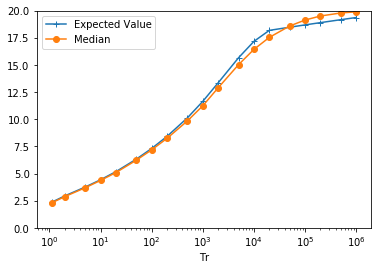

In [10]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir,index_col=0)

mean_curve_precip['Tr'] = 1/mean_curve_precip.index.to_numpy()
mean_curve_precip=mean_curve_precip.set_index('Tr')

mean_curve_precip.rename(columns = {'Q_Mean_cfs':'Expected Value', 'Q_Median_cfs':'Median'}, inplace = True)
mean_curve_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, PMP))

mean_curve_precip

### Fit GEV to Mean Precipication Curve (Find GEV parameters)

In [11]:
#Find GEV parameters for the median curve
df_GEV_parameters_E = GEV_parameters_Fit(mean_curve_precip, 'Expected Value', PMP)
GEV_parameters_E = df_GEV_parameters_E.to_numpy().transpose()[0]
df_GEV_parameters_E

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.969966851808316
            Iterations: 17
            Function evaluations: 94
            Gradient evaluations: 17


,GEV Expected Value
mu,2.701175
sigma,0.634685
xi,-0.189014


### Plot Fitted GEV Distribution and Mean Precipitation Curve

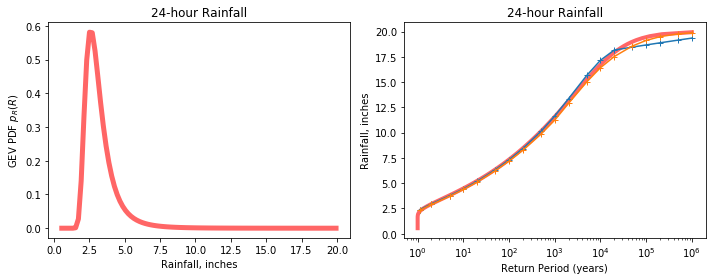

In [12]:
# Define figure including figure dimensions
fig, ((fig1a, fig1b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#fig, ax = plt.subplots(1, 1)

Precip = np.linspace(PPF_GEV(10**-100, GEV_parameters_E, PMP), PPF_GEV(.999999, GEV_parameters_E, PMP), 100)

Return_Period_Precip_E=1/(1-CDF_GEV(Precip, GEV_parameters_E, PMP))

#Create First Panel Figure
fig1a.plot(Precip, PDF_GEV(Precip, GEV_parameters_E, PMP) ,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
fig1a.set_xlabel('Rainfall, inches'),fig1a.set_ylabel('GEV PDF $p_R(R)$'), fig1a.set_title('24-hour Rainfall')

#Create Second Panel Figure

fig1b.set_xscale('log')
fig1b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=4, alpha=0.6, label='genextreme pdf')

mean_curve_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True)
mean_curve_precip['Median'].plot(style=['+-','o-','.--','s:'],logx=True)

fig1b.set_xlabel('Return Period (years)'),fig1b.set_ylabel('Rainfall, inches'), fig1b.set_title('24-hour Rainfall')

plt.tight_layout()
plt.show()

### Hydrology 2 Events

In [13]:
#Here add in script that processes the mean curve data points that are equivalent in RI to the original NOAA data points

#Return Intervals where precipitation already is calculated for the mean precip. curve.
RI_data = np.array([ 2, 5, 10, 50, 100, 200, 500, 1000, 2000])

df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'Expected Value', RI_data , CN, mu)
df_weights_rainfall

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2499.359190522618
Bin Ceiling = 2499.359190522618, Bin Average = 2000, Bin Floor = 1646.4348997501102
Bin Ceiling = 1646.4348997501102, Bin Average = 1000, Bin Floor = 684.6386139197976
Bin Ceiling = 684.6386139197976, Bin Average = 500, Bin Floor = 384.0992762304195
Bin Ceiling = 384.0992762304195, Bin Average = 200, Bin Floor = 125.57868714043593
Bin Ceiling = 125.57868714043593, Bin Average = 100, Bin Floor = 81.85348792961594
Bin Ceiling = 81.85348792961594, Bin Average = 50, Bin Floor = 34.23629622009167
Bin Ceiling = 34.23629622009167, Bin Average = 25, Bin Floor = 19.204947290452864
Bin Ceiling = 19.204947290452864, Bin Average = 10, Bin Floor = 6.291234062174133
Bin Ceiling = 6.291234062174133, Bin Average = 5, Bin Floor = 4.091126895036784
Bin Ceiling = 4.091126895036784, Bin Average = 2, Bin Floor = 1.2637018115675756


,Bin Floor,Bin Celing,Event Weight,Expected Value,Runoff
2.0,1.263702,4.091127,0.546894,2.954968,0.829794
5.0,4.091127,6.291234,0.085480,3.765830,1.361735
10.0,6.291234,19.204947,0.106881,4.437855,1.848939
25.0,19.204947,34.236296,0.022861,5.487854,2.669038
50.0,34.236296,81.853488,0.016992,6.332596,3.366538
100.0,81.853488,125.578687,0.004254,7.317501,4.210336
200.0,125.578687,384.099276,0.005360,8.429844,5.192662
500.0,384.099276,684.638614,0.001143,10.132771,6.739344
1000.0,684.638614,1646.434900,0.000853,11.650607,8.148618
2000.0,1646.434900,2499.359191,0.000207,13.358280,9.758296


# Hydrology 3
### Retreive Max. Potential Retention Variability and Distribution Parameters

In [14]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

#Define Probability for each partition of the max. potential retention distribution.
Delta_P=1/n_partition

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn

[ 0.46721141  0.96124733  1.32838278  1.64924009  1.94405423  2.2221562
  2.48886925  2.74763694  3.00089286  3.25048078  3.49788284  3.74435567
  3.99101879  4.23891713  4.48906994  4.74251339  5.00034219  5.26375528
  5.53411072  5.81299719  6.10233328  6.40451286  6.72263008  7.06084797
  7.42504473  7.82404899  8.27229238  8.79658066  9.45935888 10.55418328]


,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet)
1,54,73,87,1.691003,2.60077,44.909981,54.000151,73.000117,86.999903


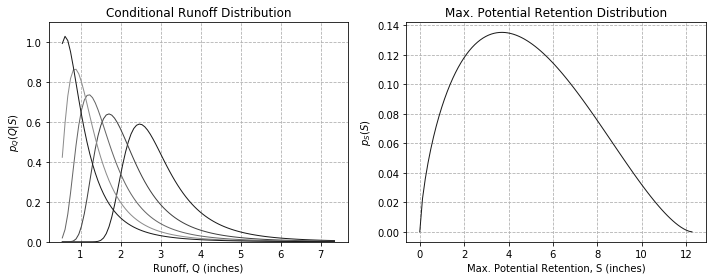

In [15]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

#Runoff x-axis values 
Q = np.linspace(PPF_GEV(10**-100, GEV_parameters_E, PMP), PPF_GEV(0.99, GEV_parameters_E, PMP), 100)

#Max. Potential Retention x-axis values
S = np.linspace(0, S_limit, 100)

fig, ((fig2a, fig2b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#Plot Figure 2a
fig2a.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2a.plot(Q, np.transpose([PDF_QlS(Q, S1, mu, GEV_parameters_E, PMP) for S1 in SA]))
fig2a.grid(linestyle='--')
fig2a.set_ylim((0, 1.1))
fig2a.set_xlabel('Runoff, Q (inches)'),fig2a.set_ylabel('$p_Q(Q | S)$'), fig2a.set_title('Conditional Runoff Distribution')

#Plot Figure 2b
fig2b.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2b.plot(S, (1/S_limit)*stats.beta(alpha, beta).pdf(S/S_limit))
fig2b.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig2b.set_xlabel('Max. Potential Retention, S (inches)'),fig2b.set_ylabel('$p_S(S)$'), fig2b.set_title('Max. Potential Retention Distribution')

plt.tight_layout()
plt.show()

## Runoff as a function of the return period

In [16]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ ))

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)


Probability of zero runoff = 0.0028570531964487683 
Error in calculation of Probabilibity of zero runoff = 2.011771767513965e-09 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -0.00024136113561978867


### Determine Runoff Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [17]:
#tck_RI_Q, tck_Q_RI respectively are cubic spline interpolation functions for runoff as a function of return period and return period as a function of runoff, respectively.
tck_RI_Q, tck_Q_RI, df_weights_runoff = runoff(Return_Intervals, RI_upper_bound, mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
df_weights_runoff

../../core\hydromet_stratified.py:128: RuntimeWarning: invalid value encountered in sqrt
  return (Q+2*S+np.sqrt(Q)*np.sqrt(Q+4*S))/(2*np.sqrt(Q)*np.sqrt(Q+4*S))* \
../../core\hydromet_stratified.py:129: RuntimeWarning: invalid value encountered in sqrt
  PDF_GEV(1/2*(Q+np.sqrt(Q)*np.sqrt(Q+4*S)+2*S*mu), GEV_parameters, PMP)
C:\Users\mbartlettjr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
../../core\hydromet_stratified.py:154: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(Avg_Q_integrand, lower_bound, upper_bound, args=(mu, GEV_parameters, PMP, partition_avg, Delta_P))


Bin Ceiling = 3700.0, Bin Floor 1.0


../../core\hydromet_stratified.py:154: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(Avg_Q_integrand, lower_bound, upper_bound, args=(mu, GEV_parameters, PMP, partition_avg, Delta_P))


Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0
Bin Ceiling = 1.0, Bin Floor 1.0


,Bin Floor,Bin Celing,Event Weight,Runoff
2,1.0,1.0,0.00000,0.700387
5,1.0,1.0,0.00000,1.573986
10,1.0,1.0,0.00000,2.199204
25,1.0,1.0,0.00000,3.044855
50,1.0,1.0,0.00000,3.764737
100,1.0,1.0,0.00000,4.587024
200,1.0,1.0,0.00000,5.537083
500,1.0,1.0,0.00000,7.023462
1000,1.0,1.0,0.00000,8.343878
2000,1.0,1.0,0.00000,9.841985


### Plot runoff distribution

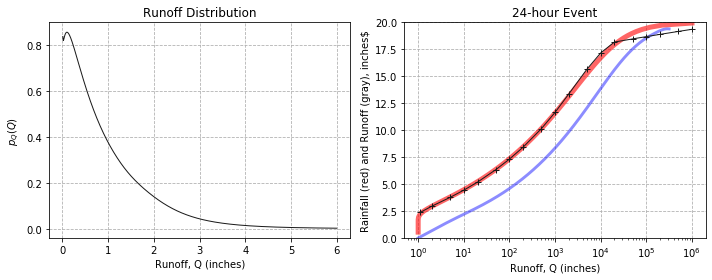

In [18]:
fig, ((fig3a, fig3b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

# x-axis value for the max. potential retention distribution
Q1= np.linspace(.01, 6, 1000)
Return_PeriodQ = np.linspace(1, 10**5.5, 100000)

#Plot Figure 3a
fig3a.set_prop_cycle(custom_cycler)
fig3a.plot(Q1,PDF_Q(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P))
fig3a.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig3a.set_xlabel('Runoff, Q (inches)'),fig3a.set_ylabel('$p_Q(Q)$'), fig3a.set_title('Runoff Distribution')

#Plot Figure 3b
fig3b.set_xscale('log')
fig3b.set_prop_cycle(custom_cycler)
#Return Inteval vs Runoff
#fig3b.plot(Return_PeriodQ, Q_line, lw =5, alpha=.1)
#Plot Runoff vs Return interval based on the intepolation function
fig3b.plot(Return_PeriodQ, interpolate.splev(Return_PeriodQ, tck_RI_Q, der=0), 'b', lw =2.9, alpha=.45)
#Return Interval vs Rainfall (i.e., Precipitation)
fig3b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
#NOAA Atlas 14 values
mean_curve_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 18))
fig3b.grid(linestyle='--')
fig3b.set_ylim((0, PMP))
fig3b.set_xlabel('Runoff, Q (inches)'),fig3b.set_ylabel('Rainfall (red) and Runoff (gray), inches$'), fig3b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Plot maximum potential distribution conditional on runoff

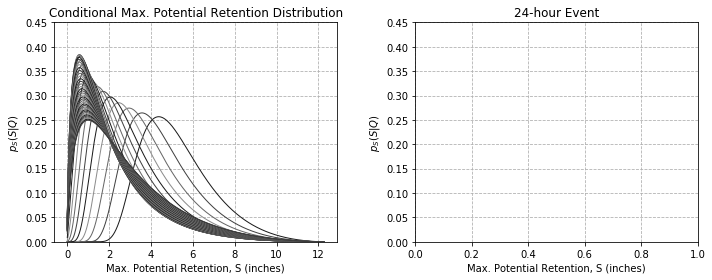

In [19]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

fig, ((fig4a, fig4b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

S1= np.linspace(.01, S_limit, 1000)
S2= np.linspace(.01, S_limit, 10)

#Plot Figure 4a
fig4a.set_prop_cycle(custom_cycler)
QA=np.linspace(.5, 10 , 50)
fig4a.plot(S1, np.transpose([PDF_SlQ(S1, Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit) for Q1 in QA]))
fig4a.grid(linestyle='--')
fig4a.set_ylim((0, .45))
fig4a.set_xlabel('Max. Potential Retention, S (inches)'),fig4a.set_ylabel('$p_S(S | Q)$'), fig4a.set_title('Conditional Max. Potential Retention Distribution')

#Plot Figure 4b
fig4b.set_prop_cycle(custom_cycler)
QA=np.linspace(2, 10 , 4)
#fig4b.plot(S2, np.transpose([CDF_SlQ(S2, Q1, mu, GEV_parameters_E, alpha, beta, S_limit) for Q1 in QA]))
fig4b.grid(linestyle='--')
fig4b.set_ylim((0, .45))
fig4b.set_xlabel('Max. Potential Retention, S (inches)'),fig4b.set_ylabel('$p_S(S | Q)$'), fig4b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [20]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit)
df_runoff_SR1

Calculating Median S for Runoff = 0.7003871569996457
Calculating Median S for Runoff = 1.5739856062322792
Calculating Median S for Runoff = 2.1992037373615045
Calculating Median S for Runoff = 3.044855393955567
Calculating Median S for Runoff = 3.7647367096658186
Calculating Median S for Runoff = 4.58702361212291
Calculating Median S for Runoff = 5.537083426870709
Calculating Median S for Runoff = 7.023461538591496
Calculating Median S for Runoff = 8.343877977788857
Calculating Median S for Runoff = 9.841985343078486
Calculating Median S for Runoff = 10.796941870580085
Calculating Median S for Runoff = 13.70558197918598


,Bin Floor,Bin Celing,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,1.0,1.0,0.00000,0.700387,4.572424,3.088165,4.249640,2.960527
5,1.0,1.0,0.00000,1.573986,2.805238,3.591868,2.374916,3.349424
10,1.0,1.0,0.00000,2.199204,2.236848,4.022534,1.783471,3.721542
25,1.0,1.0,0.00000,3.044855,2.100719,4.894549,1.551148,4.486109
50,1.0,1.0,0.00000,3.764737,2.158364,5.730030,1.584053,5.282497
100,1.0,1.0,0.00000,4.587024,2.265394,6.702803,1.688362,6.237395
200,1.0,1.0,0.00000,5.537083,2.394891,7.821964,1.821904,7.346336
500,1.0,1.0,0.00000,7.023462,2.580240,9.546335,2.020010,9.065463
1000,1.0,1.0,0.00000,8.343878,2.723035,11.051035,2.174037,10.568707
2000,1.0,1.0,0.00000,9.841985,2.863261,12.732177,2.326734,12.250438


## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [21]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta,S_limit)
df_runoff_SR2

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall,Event Weight,Runoff,Avg. S (Upper 50%),Rainfall
2,0.000000,0.700387,3.219408,2.535979,0.000000,0.700387,5.925439,3.602341
5,0.000000,1.573986,1.499853,2.813262,0.000000,1.573986,4.110624,4.271714
10,0.000000,2.199204,0.980565,3.130268,0.000000,2.199204,3.493132,4.780045
25,0.000000,3.044855,0.795083,3.858300,0.000000,3.044855,3.406355,5.765952
50,0.000000,3.764737,0.803272,4.605720,0.000000,3.764737,3.513456,6.680245
100,0.000000,4.587024,0.857124,5.496742,0.000000,4.587024,3.673665,7.730519
200,0.000000,5.537083,0.929309,6.533577,0.000000,5.537083,3.860473,8.929568
500,0.000000,7.023462,1.039986,8.151043,0.000000,7.023462,4.120494,10.760188
1000,0.000000,8.343878,1.127523,9.575570,0.000000,8.343878,4.318547,12.345813
2000,0.000000,9.841985,1.215555,11.179056,0.000000,9.841985,4.510968,14.106485


---